# Обучение YOLO для NNIE процессора Hi3559


Исходные материалы:
- https://www.programmersought.com/article/458411298417/
- https://github.com/mahxn0/Yolov5-Hisi3559a-Train

## Подготовка

Действия выполнялись в Ubuntu-22.04 под WSL2 и на виртуальном сервере Ubuntu-20.02.


0. Установка Anaconda (https://docs.vultr.com/how-to-install-miniconda-on-ubuntu-22-04)
   1. `wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh`
   2. `bash Miniconda3-latest-Linux-x86_64.sh`

1. Скачать репозиторий YOLOv5
    1. `git clone https://github.com/ultralytics/yolov5.git`
    2. `cd yolov5`
    3. ???? `git reset --hard 69be8e738` ????

    Примечание: зависимости ставил из YOLOv5 v5.0 (69be8e738), а обучение запускал на YOLOv5 v7.0 (915bbf2), поскольку есть конфликт зависимостей v7.0 и python 3.7.9. Возможно, если повысить версию Python, то можно сразу выгружать v7.0.

2. Настроить виртуальное окружение в Anaconda
   1. `conda create --name hi_yolov5 python=3.7.9 -y`
   2. `conda activate hi_yolov5`
   3. Отредактировать requirements.txt:
      - удалить строки Coremltools, onnx, Scikit-Learn "#", 
      - добавить строку "onnx-simplifier"
   4. `pip install -r requirements.txt`

## Загрузка датасета

In [10]:
%cd ..
%pwd


/home/ubuntu/otus_cv/hw_final/hi_train


'/home/ubuntu/otus_cv/hw_final/hi_train'

In [11]:
%cd yolov5

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="G17cDggpZioiUyOSqOsJ")
project = rf.workspace("paul-nlfem").project("od_ai")
version = project.version(14)
dataset = version.download("yolov5")

/home/ubuntu/otus_cv/hw_final/hi_train/yolov5
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to OD_AI-14 in yolov5pytorch:: 100%|██████████| 4598/4598 [00:00<00:00, 6484.55it/s]


In [12]:
YOLO5_PATH = %pwd
print(YOLO5_PATH)
%cat {dataset.location}/data.yaml

/home/ubuntu/otus_cv/hw_final/hi_train/yolov5
names:
- harvester
- person
- post
- tractor
nc: 4
roboflow:
  license: CC BY 4.0
  project: od_ai
  url: https://universe.roboflow.com/paul-nlfem/od_ai/dataset/14
  version: 14
  workspace: paul-nlfem
test: ../test/images
train: OD_AI-14/train/images
val: OD_AI-14/valid/images


## Модификация архитектуры сети

Опциональные шаги, оставлю для истории, поскольку у нас используется собственный датасет:
> Modify the training parameters and model structure  
>	 A. Modify the number of categories, category names, trains/test/val in the data/coco.yaml file, and modify it according to your own project planning  
>	 B. Modify the number of categories in the Models/YOLOV5s.yaml file  


>	 C. Modify the network structure in the Models/YOLOV5S.yaml, modify the Focus layer to convolutional layer, and set the Stride to 2  
	
  backbone:
```
  # [from, number, module, args]
  # [[-1, 1, Focus, [64, 3]],  # 0-P1/2
  [
   [-1, 1, Conv, [64, 3, 2]],
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]
```

     Or use YOLOV5 Release6.0 version has removed the Focus layer,
  	backbone:
```
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2 <--- update
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]
```
     Or directly
  https://github.com/mahxn0/Yolov5-Hisi3559a-Train.git

## Обучение кастомной сети на кастомном датасете

In [16]:
%cd $YOLO5_PATH
!python3 train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/yolov5s.yaml --weights '' --name yolov5s_results  --cache

/home/ubuntu/otus_cv/hw_final/hi_train/yolov5
train: weights=, cfg=./models/yolov5s.yaml, data=/home/ubuntu/otus_cv/hw_final/hi_train/yolov5/OD_AI-14/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 366 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v7.0-0-g915bbf29 Python-3.7.12 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3080, 10018MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_

In [19]:
%ls runs/train/yolov5s_results4/weights

!python3 detect.py --weights runs/train/yolov5s_results4/weights/best.pt --img 416 --conf 0.4 --source OD_AI-14/test/images/

best.pt  last.pt
detect: weights=['runs/train/yolov5s_results4/weights/best.pt'], source=OD_AI-14/test/images/, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-0-g915bbf29 Python-3.7.12 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3080, 10018MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/142 /home/ubuntu/otus_cv/hw_final/hi_train/yolov5/OD_AI-14/test/images/12742849_163405017374570_6774044920778989438_n_jpg.rf.be138abb6ecf6fbbcedab3ab970da0d9.jpg: 416x416 (no detections), 8.2ms
image 2/142 /home/ubuntu/otus_cv/hw_final/hi_train/yolov5/OD_AI-14/test/images/168153-17032596_jp

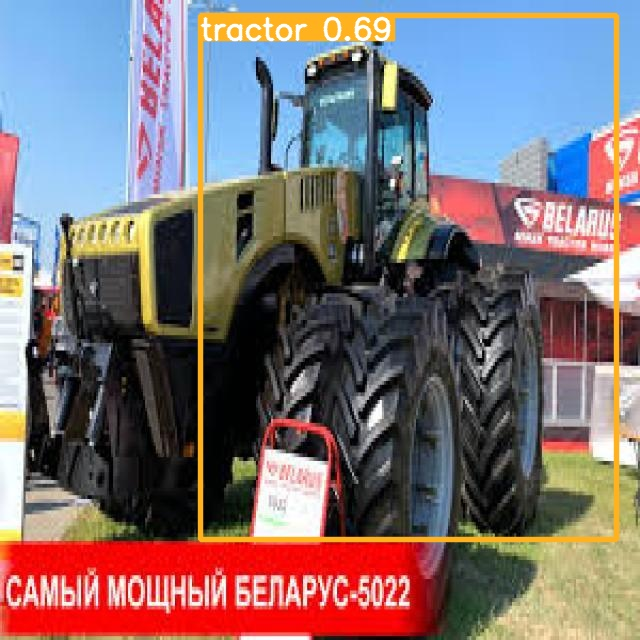

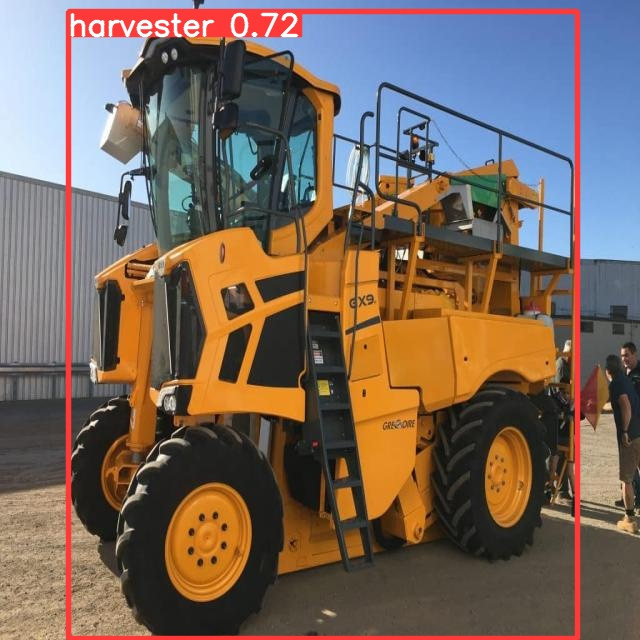

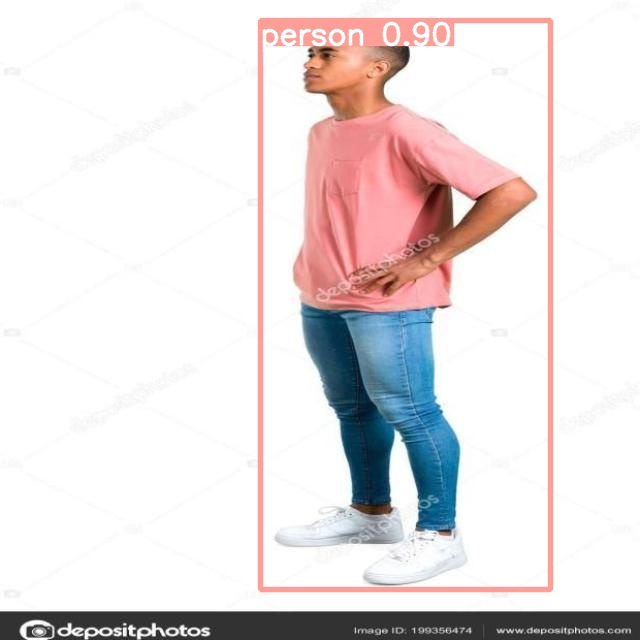

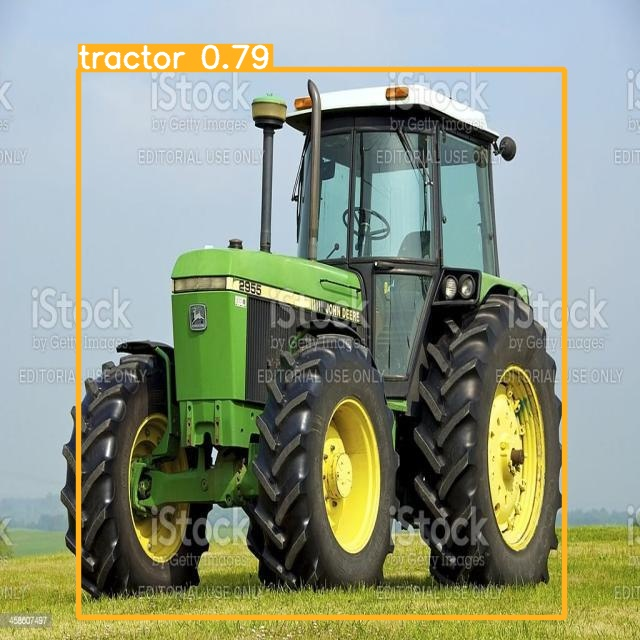

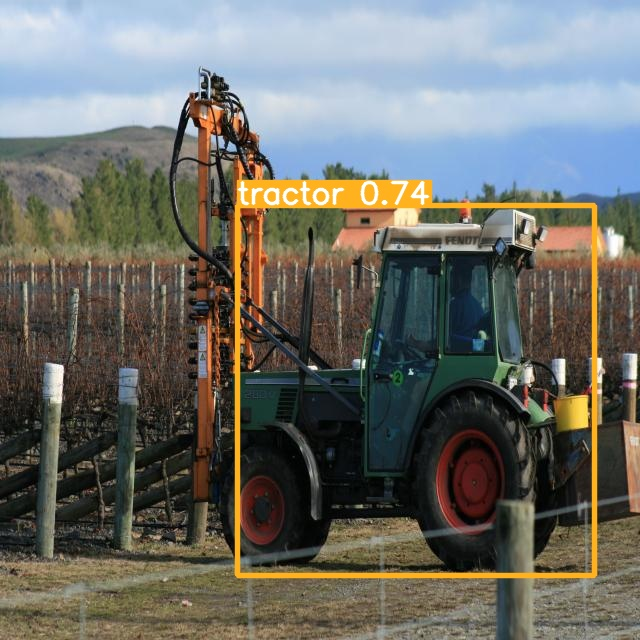

In [23]:
import glob
from IPython.display import Image, display

for imageName in glob.glob(f'{YOLO5_PATH}/runs/detect/exp/*.jpg')[50:55]: #assuming JPG
    display(Image(filename=imageName))

## Экспорт весов

 5) Model export
	`python models/export.py --weights weights/last.pt`
	
 6) Model simplification
	 `python -m onnxsim Weights/Last.onnx Weights/Simple.onnx`

In [31]:
%pwd
!python export.py --weights runs/train/yolov5s_results4/weights/last.pt --include onnx

export: data=data/coco128.yaml, weights=['runs/train/yolov5s_results4/weights/last.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-0-g915bbf29 Python-3.7.12 torch-1.13.1+cu117 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from runs/train/yolov5s_results4/weights/last.pt with output shape (1, 25200, 9) (13.7 MB)

ONNX: starting export with onnx 1.14.1...
ONNX: export success ✅ 0.8s, saved as runs/train/yolov5s_results4/weights/last.onnx (27.2 MB)

Export complete (1.2s)
Results saved to /home/ubuntu/otus_cv/hw_final/hi_train/yolov5/runs/train/yolov5s_results4/weights
Detect:          python detect.py --weights runs/train/yolov5s_results4/weights/last.onnx

In [32]:
!python -m onnxsim runs/train/yolov5s_results4/weights/last.onnx runs/train/yolov5s_results4/weights/last_simple.onnx 

Installing onnxruntime by `/home/ubuntu/miniconda3/envs/hi_yolov5/bin/python -m 
pip install onnxruntime`, please wait for a moment..
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 11.7 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 9.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 38.5 MB/s eta 0:00:00
Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃            ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Add        │ 10             │ 10               │
│ Concat     │ 17             │ 17               │
│ Constant   │ 148            │ 138              │
│ Conv       │ 60             │ 60               │
│ MaxPool    │ 3              │ 3          

## Конвертация в CAFFE

https://github.com/xxradon/ONNXToCaffe

1. Установить ONNXToCaffe
    - `git clone --recursive https://github.com/onnx/onnx.git`
    - `cd onnx`
    - установить cmake, если не установлен: `sudo apt install cmake`
    - `python setup.py install`
    - cd ..
    - sudo apt install caffe-cpu
    - `git clone https://github.com/xxradon/ONNXToCaffe.git`
    - cd ONNXToCaffe


cd yolov5_onnx2caffe

Modify Convertcaffe.py Midth Road  

 Set onnx_path (after simplified onnx models transformed above), Prototxt_Path

python convertCaffe.py



In [3]:
cd yolov5

/home/ubuntu/otus_cv/hw_final/hi_train/yolov5


In [4]:
# python convertCaffe.py ./model/MobileNetV2.onnx ./model/MobileNetV2.prototxt ./model/MobileNetV2.caffemodel

!python ../ONNXToCaffe/convertCaffe.py runs/train/yolov5s_results4/weights/last_simple.onnx  runs/train/yolov5s_results4/weights/last.prototxt runs/train/yolov5s_results4/weights/last.caffemodel

Traceback (most recent call last):
  File "../ONNXToCaffe/convertCaffe.py", line 10, in <module>
    import caffe
ModuleNotFoundError: No module named 'caffe'
